## Viscous Inverse Design
This notebook demonstrates the use of gradients from viiflow for fully viscous inverse design.
It defines a target pressure distribution from one airfoil and, coming from another airfoil, tries to find the shape necessary to arrive at this target pressure.
It uses virtual displacements, which do not necessitate the recalculation of the panel operator.
Instead, it uses the same model used for the effect of boundary layer thickness onto the flow for modification of the airfoil shape.

The heart of this notebook is a Gauss-Newton iteration which solves for these virtual displacements.
Instead of trying to solve the pressure distribution exactly, the iteration sovles a least-squares problem that joins the pressure difference with regularizing terms.
Fully viscous inverse design is not a straightforward problem. There are several ways an optimizer may *cheat*, for example

* The velocity is defined by the inviscid solution of the airfoil shape plus boundary layer thickness. An optimizer can therefore choose to reduce the thickness of the airfoil if for some reason a thick boundary layer leads to the target velocity distribution.
* Kinks in the desired velocity are, in the case below, due to laminar-turbulent transition. However, an optimizer can choose to model this kink by an actual kink in the airfoil.

To alleviate this, the pressure error is appended by

* the first-order difference of the error, penalizing kinks in the pressure distribution
* the boundary layer thickness, penalizing thick boundary layers

The parameters chosen to increrase/decrease the penalties were chosen ad-hoc by trial and error.
In addition, the nodes very close to the stagnation point are not modified.
Every iteration then performs
$$ 
y^{k+1} = y^k - \lambda {\Delta y}^k\\
{\Delta y}^k = \min_{\Delta y} \| F(y^k)-\frac{\partial F}{\partial y}(y^k) \Delta y\|^2\\
\|F(y)\|^2 = \gamma_{cp}^2\|ue(y)^2-ue_{target}\|^2 + \gamma_D^2\| \frac{\partial}{\partial x} (ue(y)-ue_{target}) \|^2 + \gamma_\delta^2\| \delta_{BL}(y) \|^2,
$$
where $ue$ is the edge velocity and $1-ue^2$ is the pressure, $\delta_{BL}$ is the boundary layer thickness over the airfoil and $\frac{\partial}{\partial x}$ is not really accurate as a simple difference between values along the surface is used. This may seem like a large problem, but the effort for solving the overdetermined least-squares problem grows largely with the degrees of freedom, not the amount of equations.

Below, this procedure is used to morph the S805 airfoil into the S825 airfoil. Even with the regularizing terms, little dips that enforce the laminar-turbulent transition can still be seen when zooming in.

While this solves for an airfoil shape of a specified pressure distribution, it is probably not a very smart idea to use this for actual design. A better idea is to use first an inviscid inverse design method, e.g. conformal mapping [1, 2], and remove the discrepancies using a fully viscid iteration.
The benefit of this Gauss-Newton approach is how straightforward additional constraints can be included, e.g. only fit the suction side from .1c onwards or fit multiple target distributions at multiple angles of attack.

In [1]:
# Settings for plotting and importing
interactive_plot = False
if interactive_plot:
    %matplotlib notebook
    interactive_plot = True
    matplotlib.rcParams['figure.figsize'] = [9, 6]
else:
    %matplotlib inline
    %config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Analysis Settings
RE = 1e6
ncrit =5
Mach = 0.0
alpha = 4.0

# Read Airfoils
BASE = vft.repanel(vft.read_selig("S805.dat"),200,KAPFAC=2)
TARGET = vft.repanel(vft.read_selig("S825.dat"),200,KAPFAC=2)
# Solve target for our target cp (or more precisely edge velocity)
s = vf.setup(Re=RE,Ma=Mach,Ncrit=ncrit,Alpha=alpha)

# Internal iterations
s.Itermax = 100

# Set-up and initialize based on inviscid panel solution
[p,bl,x] = vf.init([TARGET],s)
res = None
grad = None


# Solve aerodynamic problem of target airfoil
vf.iter(x,bl,p,s,None,None)
XT0 = p.foils[0].X[0,:].copy()
UT = p.gamma_viscid[0:p.foils[0].N].copy()

# Set-up and initialize based on inviscid panel solution
[p,bl,x0] = vf.init([BASE],s)
res = None
grad = None

# Solve aerodynamic problem of current airfoil and save for later plotting
[x0,_,res,grad,_] = vf.iter(x0,bl,p,s,None,None)
XC0 = p.foils[0].X[0,:].copy()
UC = p.gamma_viscid[0:p.foils[0].N].copy()

# To interpolate from one grid to the next, suction and pressure side must have unique grid points
# That is why below a grid is created where the pressure side is appended with *-1 at the nose
XT = XT0.copy()
XC = XC0.copy()
XT[np.argmin(XT0)+1::] = 2*XT0[np.argmin(XT0)]-XT0[np.argmin(XT0)+1::]
XC[np.argmin(XC0)+1::] = 2*XC0[np.argmin(XC0)]-XC0[np.argmin(XC0)+1::]

# Interpolate target pressure onto current airfoil grid
UT = np.interp(-XC.flatten(),-XT.flatten(),np.asarray(UT[:,0]).flatten())

if interactive_plot:
    fig,ax = plt.subplots(2,1)
    ax[0].plot(p.foils[0].X[0,:],np.power(UC,2)-1,'-k')
    ax[0].plot(p.foils[0].X[0,:],np.power(UC,2)-1,'-r')
    ax[0].plot(p.foils[0].X[0,:],np.power(UT,2)-1,'2k')
    ax[0].legend(['Initial Pressure','Found Pressure','Target Pressure'])
    lines = None
    ax[1].plot(TARGET[0,:],TARGET[1,:],'2k')
    lines = vfp.plot_geometry(ax[1],p,bl,lines)
    ax[1].legend(['Target Airfoil','Initial Geometry','Found Geometry'])


Iteration 12, |res| 0.000087, lam 1.000000
Iteration 10, |res| 0.000073, lam 0.760545


In [3]:
# Weighting factors for Gauss-Newton
fac_dy = 40 # Penalty for d/dx (cp-cp_target)
facx = 5 # Penalty for thick boundary layer
fac_y0 = 1000 # Penalty for thick trailing edge or movement
difforder = 1 # 1st difference in d/dx penalty
fac_err = 16# Weighting of cp error w.r.t. above penalties

NAERO = x.shape[0]
NVD = len(XC)

x = x0.copy()
y = np.zeros(NVD)
        
# Set-up and initialize based on inviscid panel solution
[p,bl,_] = vf.init([BASE],s)
res = None
grad = None

# Solve aerodynamic problem to convergence
[x,_,_,_,_] = vf.iter(x0,bl,p,s,None,None)

for iter in range(100):

    # Find ST and do not change near there
    II = np.fabs(XT-XT[bl[0].sti])>0.001
    II[0]=False
    II[NVD-1]=False

    # Solve Aerodynamic problem
    # Lazily let viiflow not converge every iteration but also do not include the residual.
    # Just iterate until viiflow residuals are low enough as well.
    s.Itermax = 1 
    s.VirtualGradients = True
    s.Silent = True
    [x,_,res,_,gradients] = vf.iter(x,bl,p,s,None,None,[y])

    # Residual 
    RESy = fac_err*(p.gamma_viscid[0:p.foils[0].N].A1**2-UT**2)
    dRESydy = fac_err*2*np.matmul(gradients.gam_vd[0:NVD,:],np.diag(p.gamma_viscid[0:p.foils[0].N].A1))
    
    # Do not inflate or move trailing edge
    REG = np.r_[y[0]*fac_y0,y[-1]*fac_y0]
    dREGdy = np.zeros((len(REG),NVD))
    dREGdy[0,0]=fac_y0
    dREGdy[1,-1]=fac_y0

    # Penalty for non-smooth cp error
    REGdy = np.diff(p.gamma_viscid[0:p.foils[0].N].A1-UT,difforder)*fac_dy
    dREGdydy = np.diff(gradients.gam_vd[0:NVD,:],difforder,0)*fac_dy
    
    # Penalty for thick boundary layer
    REGdelta = bl[0].bl_fl.nodes.delta*facx
    dREGdeltady = gradients.delta_vd[0:NVD,:]*facx

    # Gauss-Newton step from all terms
    F = np.r_[RESy[II],REG,REGdelta,REGdy]
    dFdy = np.r_[dRESydy[II,:][:,II],dREGdy[:,II],dREGdeltady[:,II],dREGdydy[:,II]]
    dy = -np.linalg.lstsq(dFdy,F,rcond=None)[0]
    lam = 1.0

    # Ad-hoc Damping
    for k in range(len(dy)):
        lam = np.fmin(lam,0.005/abs(dy[k]))

    j =0
    for k in np.argwhere(II):
        y[k] += lam*dy[j]
        j+=1

    # Plot
    if interactive_plot:
        ax[0].lines[1].set_data(p.foils[0].X[0,:],np.power(p.gamma_viscid[0:p.foils[0].N].A1,2)-1)
        lines = vfp.plot_geometry(ax[1],p,bl,lines)
        ax[0].set_xlim(-.1,1.1)
        ax[1].set_xlim(-.1,1.1)
        fig.canvas.draw()
    
    # Print
    resaero = np.sqrt(np.matmul(res,res.T))
    print("iter %u res p:%f resaero: %f dvd:%f lam:%f"%(iter, np.sqrt(np.matmul(F,F.T)), \
                resaero,np.sqrt(np.matmul(dy,dy.T)),lam))
    if np.sqrt(np.matmul(dy,dy.T))<1e-3 and resaero<2e-3:
        print("Converged")
        break
        



Iteration 1, |res| 0.000027, lam 0.761969
iter 0 res p:62.186510 resaero: 0.000009 dvd:0.240085 lam:0.146338
iter 1 res p:50.761099 resaero: 0.005043 dvd:0.192844 lam:0.172425
iter 2 res p:41.088125 resaero: 0.009104 dvd:0.153909 lam:0.205168
iter 3 res p:33.800451 resaero: 0.009511 dvd:0.106829 lam:0.299614
iter 4 res p:27.347294 resaero: 0.013699 dvd:0.076891 lam:0.381898
iter 5 res p:25.964534 resaero: 0.017743 dvd:0.051755 lam:0.523322
iter 6 res p:24.030017 resaero: 0.021847 dvd:0.031538 lam:0.911298
iter 7 res p:14.111851 resaero: 0.026497 dvd:0.018111 lam:1.000000
iter 8 res p:12.515820 resaero: 0.031528 dvd:0.011487 lam:1.000000
iter 9 res p:9.030207 resaero: 0.034435 dvd:0.011978 lam:1.000000
iter 10 res p:9.975728 resaero: 0.036904 dvd:0.008573 lam:1.000000
iter 11 res p:6.558649 resaero: 0.035982 dvd:0.011353 lam:1.000000
iter 12 res p:8.534523 resaero: 0.035119 dvd:0.006987 lam:1.000000
iter 13 res p:13.728646 resaero: 0.049974 dvd:0.011638 lam:1.000000
iter 14 res p:7.4152

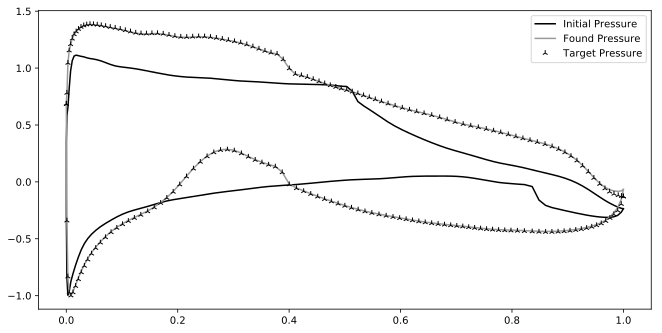

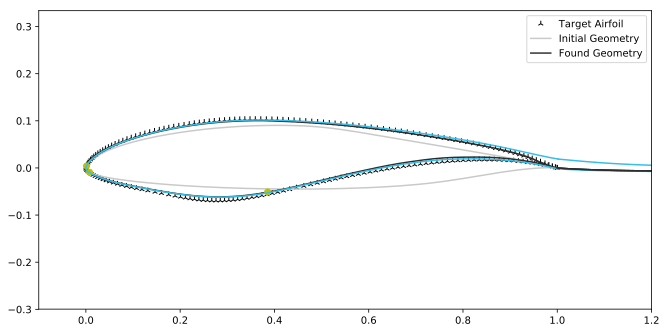

In [4]:
matplotlib.rcParams['figure.figsize'] = [11, 5.5]
fig,ax = plt.subplots(1,1)
ax.plot(p.foils[0].X[0,:],np.power(UC,2)-1,'-k')
ax.plot(p.foils[0].X[0,:],np.power(p.gamma_viscid[0:p.foils[0].N].A1,2)-1,'-',color=(0.6,0.6,0.6))
ax.plot(p.foils[0].X[0,:],np.power(UT,2)-1,'2k')
ax.legend(['Initial Pressure','Found Pressure','Target Pressure'])

fig,ax = plt.subplots(1,1)
lines = None
ax.plot(TARGET[0,:],TARGET[1,:],'2k')
lines = vfp.plot_geometry(ax,p,bl,lines)
ax.legend(['Target Airfoil','Initial Geometry','Found Geometry'])
fig.canvas.draw()

[1] Selig, Michael S., and Mark D. Maughmer. *Generalized multipoint inverse airfoil design.* AIAA journal 30.11 (1992): 2618-2625.

[2] Drela, Mark. *XFOIL: An analysis and design system for low Reynolds number airfoils.* Low Reynolds number aerodynamics. Springer, Berlin, Heidelberg, 1989. 1-12.